In [ ]:
# 변수의 shape, type, value 확인
def p(var,_name="") :
    if _name != "" : print(f'<<{_name}>>')
    if type(var)!=type([]):
        try:      print(f'Shape:{var.shape}')
        except :  pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}')

def pst(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}')

In [ ]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = [5, 3.5]

tf.__version__, keras.__version__

('2.18.0', '3.8.0')

# Timeseries classification with a Transformer model  
https://keras.io/examples/timeseries/timeseries_classification_transformer/

## Load the data: the FordA dataset
> FordA Dataset  
  3601개의 training, 1320개의 test data  
  모터 센서에 의해 포착된 엔진 소음의 측정값  
  목표는 엔진에 특정 문제가 있는지 감지하는 것   
  http://www.j-wichard.de/publications/FordPaper.pdf

In [ ]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)

root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"


x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

ps(x_train,'x_train')
ps(y_train,'y_train')
ps(x_test,'y_train')
ps(y_test,'y_test')

<<x_train>> Shape(3601, 500, 1)
<<y_train>> Shape(3601,)
<<y_train>> Shape(1320, 500, 1)
<<y_test>> Shape(1320,)


In [ ]:
p(y_train[0:10],'y_train')

<<y_train>>
Shape:(10,)
Type: <class 'numpy.ndarray'>
Values: [-1  1 -1 -1 -1  1  1  1  1  1]


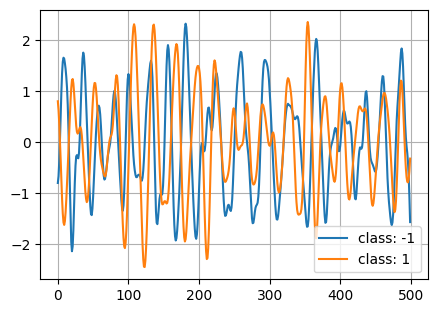

In [ ]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class: " + str(c))
plt.legend()
plt.grid()
plt.show()

In [ ]:
n_classes = len(np.unique(y_train))
p(n_classes,'n_classes')

## 0,1 <-- -1,1
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0
p(y_train[:10])

<<n_classes>>
Type: <class 'int'>
Values: 2
Shape:(10,)
Type: <class 'numpy.ndarray'>
Values: [0 1 0 0 0 1 1 1 1 1]


## Transformer model

key_dim은 모델 차원(d_model)을 헤드 개수(num_heads)로 나눈 값과 동일하게 설정   
(예: d_model = 512, num_heads = 8 → key_dim = 64)

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, tf_dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=tf_dropout)(inputs, inputs)
    x = layers.Dropout(tf_dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(tf_dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [ ]:
def build_model( input_shape,
                head_size,
                 num_heads,
                 ff_dim,
                 num_transformer_blocks,
                 mlp_units,
                 mlp_dropout,
                 tf_dropout,
                 in_conv=False ):

    inputs = keras.Input(shape=input_shape)
    x = inputs

    if in_conv :
        x = keras.layers.Conv1D(32, 5, padding='same' )(x)
        x = keras.layers.Conv1D(1, 5, padding='same' )(x)

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, tf_dropout)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x) #(bs,500)<-(bs,500,1)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

### Training

In [ ]:
input_shape = x_train.shape[1:]
head_size=256    # 256
num_heads=4      # 4
ff_dim=4         # 4
num_transformer_blocks=4 #4
mlp_units=[128]
mlp_dropout=0.4  #.4
tf_dropout=0.25 #0.25
in_conv = False

model = build_model(
    input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    mlp_units=mlp_units,
    mlp_dropout=mlp_dropout,
    tf_dropout=tf_dropout,
    in_conv = in_conv )

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 500, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 500, 1)    │      7,169 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 500, 1)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 500, 1)    │          2 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 500, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 500, 4)    │          8 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 500, 4)    │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 500, 1)    │          5 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 500, 1)    │          2 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 500, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 500, 1)    │      7,169 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 500, 1)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 500, 1)    │          2 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 500, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 500, 4)    │          8 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 500, 4)    │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 500, 1)    │          5 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 500, 1)    │          2 │ conv1d_3[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 500, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 93,130 (363.79 KB)

 Trainable params: 93,130 (363.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#keras.utils.plot_model(model, show_shapes=True,dpi=70)

In [ ]:
%%time
batch_size = 64
epochs = 150

model.compile( optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"],)

callbacks = [
    keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5, patience=10, min_lr=0.00001 ),
    keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)]

history4 = model.fit( x_train, y_train, validation_data=(x_test,y_test),
                     batch_size=batch_size, epochs=epochs,
                     callbacks=callbacks,)

Epoch 1/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 59s 557ms/step - acc: 0.5877 - loss: 0.9202 - val_acc: 0.7280 - val_loss: 0.5461 - learning_rate: 0.0010
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - acc: 0.7194 - loss: 0.6075 - val_acc: 0.7682 - val_loss: 0.4875 - learning_rate: 0.0010
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - acc: 0.7636 - loss: 0.4865 - val_acc: 0.7924 - val_loss: 0.4724 - learning_rate: 0.0010
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - acc: 0.7899 - loss: 0.4425 - val_acc: 0.8189 - val_loss: 0.4415 - learning_rate: 0.0010
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - acc: 0.8305 - loss: 0.3840 - val_acc: 0.8333 - val_loss: 0.4193 - learning_rate: 0.0010
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - acc: 0.8490 - loss: 0.3634 - val_acc: 0.8348 - val_loss: 0.3981 - learning_rate: 0.0010
Epoch 7/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - acc: 0.8625 - loss: 0.3321 - val_acc: 0.8326 - val_loss: 0.3971 - learning_rate:

Wall time: 3min 35s



In [ ]:
h1 = history4.history
metric = "acc"
max_acc = max(h1['val_' + metric])
cond = f"head_size({head_size},num_heads({num_heads}),ff_dim({ff_dim}),num_transformer_blocks({num_transformer_blocks})\n\
,mlp_units({mlp_units}),mlp_dropout({mlp_dropout}),tf_dropout({tf_dropout}),in_conv({in_conv})"
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.title(f'max Acc:{max_acc:.3f}\n'+cond)
plt.plot(h1[metric])
plt.plot(h1["val_" + metric])
plt.legend(["train", "val"])
plt.grid()

plt.subplot(122)
plt.title(f'Loss')
plt.plot(h1['loss'])
plt.plot(h1['val_loss'])
plt.semilogy()
plt.legend(["loss", "val_loss"])
plt.grid()
plt.show()

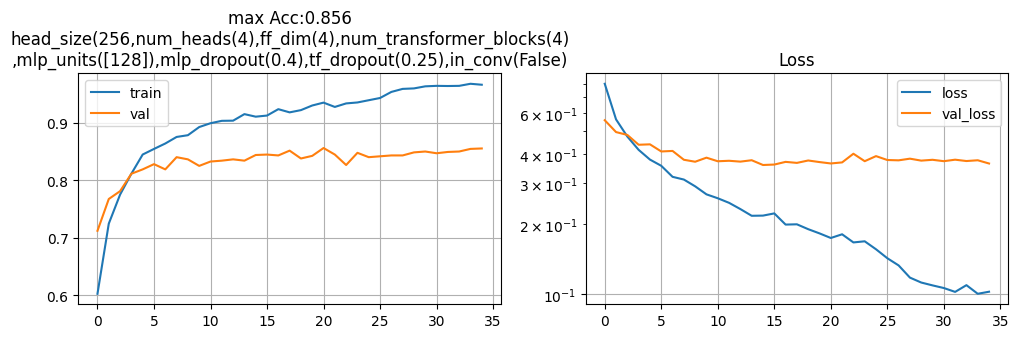

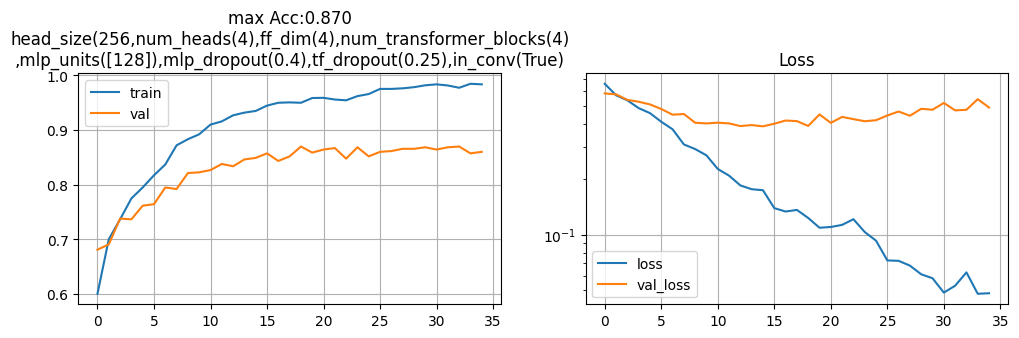

## 실습과제  
### - Position code를 추가하지 않아도 학습에 문제가 없나?    

# 대안 찾기   

## Convolutional Model

In [ ]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    x = keras.layers.Conv1D(64, 3, 1, "same")(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    x = keras.layers.Conv1D(64, 3, 1, "same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    x = keras.layers.Conv1D(64, 3, 1, "same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    gap = keras.layers.GlobalAveragePooling1D()(x)

    output_layer = keras.layers.Dense(n_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=x_train.shape[1:])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 500, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 500, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 500, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 500, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,858 (101.01 KB)

 Trainable params: 25,474 (99.51 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
keras.utils.plot_model(model, show_shapes=True,dpi=70)

### Training

In [ ]:
%%time

callbacks = [ keras.callbacks.ReduceLROnPlateau( monitor="val_loss",
                                                factor=0.5, patience=10, min_lr=0.00001 ), ]

model.compile( optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"],)

history = model.fit( x_train, y_train, batch_size=batch_size, epochs=epochs,
                    callbacks=callbacks, validation_split=0.2, )

Wall time: 43.4 s



In [ ]:
h1 = history.history
metric = "acc"
max_acc = max(h1['val_' + metric])

plt.figure(figsize=(12,3))
plt.subplot(121)
plt.title(f'max Acc:{max_acc:.3f}')
plt.plot(h1[metric])
plt.plot(h1["val_" + metric])
plt.legend(["train", "val"])
plt.grid()

plt.subplot(122)
plt.title(f'Loss')
plt.plot(h1['loss'])
plt.plot(h1['val_loss'])
plt.semilogy()
plt.legend(["loss", "val_loss"])
plt.grid()
plt.show()

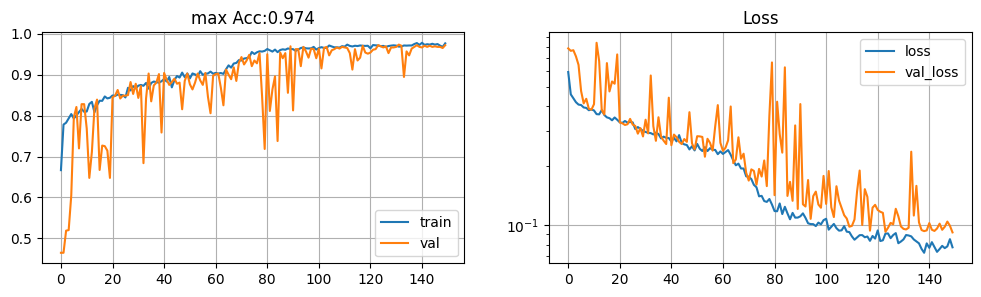